In [1]:
## This code cell will not be shown in the HTML version of this notebook
#### some helpful imports ####
# import autograd functionality
import autograd.numpy as np

# import testing libraries
import sys
sys.path.append('../')
from mlrefined_libraries import time_series_lib as timelib
from mlrefined_libraries import pid_lib as pidlib

# import dataset path
datapath = '../datasets/'

# import various other libraries e.g., for plotting, deep copying
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

# Principles of PID control

Toggle code on and off in this presentation by clicking the 'Toggle code' button below.

In [35]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# The standard PID Control Model

- with a trained Imitator or System Model in hand, we can now look at automatically controlling this Imitator to perform desired tasks


- the simplest kind of behavior we make a system obey (like e.g., temperature control and cruise control): is to make the system match a series of **training** *set points* $x_1,\,x_2,\,...,x_T$ as closely as possible


- examples of set points:
    - for cruise control / autonomous driving: speed levels to have the car drive
    - for temperature control: different temperature levels throughout the day
    - for an industrial process like water level: keep a certain level in a tank that can change throughout the day

- this involves putting our Imitator model under the authority of a Controller (or - you can say - we pass our Imitator model through a Control model that selects optimal actions for it)


- once trained the Control Model should be able to choose actions automatically so that the Imitator matches desired set points 


- that is, our Controller will choose actions $a_t$ for optimally for our Imitator so that its output $s_{t+1} = f_{\text{imitator}}\left(s_t,a_t\right)$ matches the desired set points as closely as possible (as the system allows), or that 

$$s_t \approx x_t \,\,\,\,\, \text{for} \,\,\,\,\, t=2,...,T$$

(often the initial state $s_1$ is determined by the problem, or set to a reasonable reference value) 


- once tuned properly a Control Model is often referred to as a *Control Law* or *Optimal Policy* 

- how does the Controller choose optimal actions to meet a series of set points?  


- *one way* is to train a Controller to choose actions optimally **looking backwards** to decide on the best choice of action in the present


- this is based on the desire to always be correcting for previous mistakes / *historical errors*, or how well $s_t \approx x_t$ previously


- this most popular control approach is called *Proportional Integral Derivative or PID* ontrol 


- this is a simple *parameterized dynamic system with unlimited memory* that captures historical *error* between our sequence of training set points and the corresponding states of our system


- as a graphical model it looks like this

<figure>
<p>
<img src= 'images/pid_control_diagram.png' width="100%" height="100%" alt=""/>
</p>
</figure>

<figure>
<p>
<img src= 'images/step_by_step.png' width="100%" height="100%" alt=""/>
</p>
</figure>

- here we have used the *signed error* $e_t = x_t - s_t$ as historical feedback to the Controller Model: $f_{\text{controller}}\left(e_t\right)$


- using the signed error is a convention, you could use another (e.g., absolute value of the error)


- we uses a linear combination of this (and its history and/or its derivatives) to learn how to choose actions optimally


- the simplest parameterized controller (a *Proportional controller*) uses a linear combination of this (signed) error to determine the next action to take

\begin{equation}
f_{\text{controller}}\left(e_t;\Theta_{\text{controller}}\right) = a_t =  w_0 + w_1e_t
\end{equation}


- this is a function with weights we need to tune properly in order for the controller to properly choose actions


- it is called a *Proportional controller* because the action $a_t$ is literally being made proportional to the signed error of the system at the prior state

<figure>
<p>
<img src= 'images/error_curve.png' width="100%" height="100%" alt=""/>
</p>
</figure>

- a common extension of this idea: use a summary statistic of the history of the error as well as well 


- this is usually chosen to be the *integral of the error*

\begin{equation}
h^e_t = h^e_t + \frac{1}{D}e_t
\end{equation}

where $\frac{1}{D}$ is the gap between steps, but in principle any dynamic system with unlimited memory will work


- adding the integral (or history) of the error gives the controller *context*, as the integral summarizes how the error has changed in the past


- this is what we mean when we say that a PID Controller 'looks backward' to decide on the best choice of action in the present

- adding the history $h^e_t$ term to our parameterized action function / control model gives the parameterized update

\begin{equation}
a_t = w_0 + w_1e_t + w_2h^e_t
\end{equation}

- this is a so-called *Proportional Integral* controller - one of the most common automatic controller used today in practice (for set-point matching automatic control problems)


- notice: this history of the error is now an explicit input to our Controller 

\begin{equation}
f_{\text{control}}\left(e_t,h^e_t ; \Theta_{\text{controller}} \right) = a_t = w_0 + w_1e_t + w_2h^e_t
\end{equation}

- one final common addition: the derivative of the error: $\frac{e_t - e_{t-1}}{D}$


- proportional information derivative or *local difference* of the error can be added as well, tacking on another term as to the action update


\begin{equation}
a_t = w_0 + w_1e_t + w_2h_t + w_3\frac{e_t - e_{t-1}}{D}
\end{equation}

- using this update in a Control Model we have the so-called *Proportional Inegral Derivative* (PID) controller.


- our Control Model now takes in two prior error terms 

# Tuning the weights of a PID Control Model

- how do we tune these weights properly - so that our controller learns how to produce the best actions to lead our system model to match our training set points?


- traditional (non machine-learning) approaches PID controller tuning involve "voodoo" and a lot of human trial and error 


- see e.g., the recommendations for tuning on stackoverflow and youtube (note here: $w_1 = K_p$, $w_2 = K_i$, and $w_3 = K_d$)

https://robotics.stackexchange.com/questions/167/what-are-good-strategies-for-tuning-pid-loops

https://www.youtube.com/watch?v=VVOi2dbtxC0&t=1050s


- note: 'traditional' does not mean that 'old' - this is how many people tune their controllers today

- why so much 'voo-doo' and human trial and error for PID tuning?


- because the traditional way of doing PID control already involves one understand an enormous amount of specialized information

    - for Imitator / System modeling: the traditional way is to use 'first principles' differential equations modeling
    
    - this can lead to system models that are - by their very nature - highly unstable
    
    - this involves building up not only a steep mathematical knowledge stack, but expert knowledge in a particular domain (e.g., physics, chemistry, robotics, etc.,)
    
    
- things often not included in traditional automatic control pedagogy

    - programming / basic CS
    - machine learning / deep learning basics (as an alternative to differential equations modeling)
    - mathematical optimization (although there is some emphasis on this for advanced students of automatic control, the approaches taken are very limiting = only special structures like QP are studied)

# The ML perspective on PID tuning

- but 'automatic parameter tuning' is the 'bread and butter' for machine learning folks - so what do we need to do to auto-tune our PID parameters?


- Like everything else: we need to form a cost function (whose minimum recovers correctly tuned parameters)!


- to design a proper cost, lets look at our entire controller pipeline- including our system model


- to keep things simple we will perform these derivations using the simplest Proportional (P) controller, but everything that follows is the same for PI and PID controllers as well

<figure>
<p>
<img src= 'images/control_model.png' width="100%" height="100%" alt=""/>
</p>
</figure>

- our basic Proportional controller takes in the current (signed) error $e_t = x_t - s_t$ and returns the action $a_t$ 


\begin{equation}
f_{\text{control}}\left(e_t\right) = a_t
\end{equation}


- we then feed this action into our Imitator model to get our next state $s_{t+1}$


\begin{equation}
f_{\text{imitator}}\left(s_t, a_t \right) = f_{\text{imitator}}\left(s_t,\, f_{\text{control}}\left(e_t\right) \right) = s_{t+1} 
\end{equation}


- now ideally - we want these actions made *so that this next state matches the input set point*, that is

\begin{equation}
s_{t+1} \approx x_{t+1}
\end{equation}


- in other words, we want the *error* $e_{t+1} = x_{t+1} - s_{t+1}$ to be small in magnitude

- so why not tune $\Theta_{\text{controller}}$ to minimize the average e.g., squared error over the entire sequence of *training set points* $x_1,...,x_T$ 


\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(e_{t+1}\right)^2 = \frac{1}{T-1}\sum_{t=1}^T\left(s_{t+1} - x_{t+1}\right)^2
\end{equation}


- we ignore the error on our initial state $s_1$ since we cannot adjust it (its given by the problem at hand!  e.g., with cruise control the car starts with 0 velocity)


- if unwravel the definition of $s_{t+1}$ and express it in terms of our system and control model this is equivalently


\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(f_{\text{imitator}}\left(s_t,\, f_{\text{control}}\left(e_t;\Theta_{\text{controller}}\right) \right) - x_{t+1}\right)^2
\end{equation}


- note here: we are minimizing over the *Controller parameters* $\Theta_{\text{controller}}$, **not** the parameters of our Imitator model


- the weights of our imitator have already been tuned as necessary to real action/state data (another way to think about it: they are regularized so that the system matches a real set of input/output data)


-  our goal in optimizing our Controller parameters is to solidify our *Optimal Control Law* so that we learn an entire sequence of optimal actions $a_1,\,a_2,\,...,a_{T-1}$


- thus we are getting at our optimal set of actions indirectly (via a parameterized function)

- Lets look at a simple implementation of a PID controller

In [8]:
# a simple implementation of a PID controller
def PID_controller(e_t,h_t,d_t,w):    
    # note here in terms of inputs
    # e_t = current error
    # h_t = integral of error
    # d_t = derivative of error
    return w[0] + w[1]*e_t + w[2]*h_t + w[3]*d_t

In [9]:
# loop for evaluating control model over all input/output action/state pairs
# Our inputs here:
# s_1 - the initial condition state
# x - sequence of training set points
# w - the control model parameters
def control_loop(x,w):
    # initialize key variables and containers
    s_t = copy.deepcopy(s_1)
    h_t = 0
    d_t = 0
    frac = 1/float(np.size(x))
    action_history = []
    state_history = [s_t]
    error_history = []
    
    # loop over training set points and run through controller, then 
    # system models
    for t in range(np.size(x) - 1):
        # get current set point
        x_t = x[:,t]

        # update error
        e_t = x_t - s_t
        error_history.append(e_t)
        
        # update integral of error
        h_t = h_t + frac*e_t
        
        # update derivative of error 
        if t > 0:
            d_t = frac*(error_history[-1] - error_history[-2])
            
        # send error, integral, and derivative to PID controller
        a_t = PID_controller(e_t,h_t,d_t,w)
        
        # clip a_t to match system specifications?
                        
        # send action to system model
        s_t = tuned_system_model(s_t,a_t)
        
        # store state output, and actions (for plotting)
        state_history.append(s_t)
        action_history.append(a_t)

    # transition to arrays
    state_history = np.array(state_history)[np.newaxis,:]
    action_history = np.array(action_history)[np.newaxis,:]
    
    # return velocities and control history
    return state_history,action_history

In [10]:
# an implementation of the least squares cost for PID controller tuning
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares(w,x):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    state_history,action_history = control_loop(x,w)

    # compute least squares error between real and predicted states
    cost = np.sum((state_history[:,1:] - x[:,1:])**2)
    return cost/float(x.shape[1]-1)

#### <span style="color:#a50e3e;">Example: 1 </span> Cruise control

- a `Python` implementation of our `control_model` for the *cruise control* problem.  Notice at each update step the action is clipped to lie in the range $[-50,100]$ - which is the angle of the pedal against the floor of the car.


- because here we are using a 'true model' of the automobile we need to use a zero order optimization method - since we cannot compute the gradient of `system_model` with respect to our PID weights.

In [11]:
# create tuned system model for the car
ind = np.argmin(mylib1.train_cost_histories[0]) 
w_best = mylib1.weight_histories[0][ind]
# a_norm = mylib1.x_norm
# s_norm = mylib1.y_norm
# s_invnorm = mylib1.y_invnorm
# a_invnorm = mylib1.x_invnorm
# tuned_system_model = lambda state,action: s_invnorm(system_model(s_norm(state),a_norm(action),w_best))

tuned_system_model = lambda state,action: system_model(state,action,w_best)
s_1 = 0.0

In [12]:
# loop for evaluating control model over all input/output action/state pairs
# Our inputs here:
# s_1 - the initial condition state
# x - sequence of training set points
# w - the control model parameters
def control_loop(x,w):
    # initialize key variables and containers
    s_t = copy.deepcopy(s_1)
    h_t = 0
    d_t = 0
    frac = 1/float(np.size(x))
    action_history = []
    state_history = [s_t]
    error_history = []
    
    # loop over training set points and run through controller, then 
    # system models
    for t in range(np.size(x) - 1):
        # get current set point
        x_t = x[:,t]

        # update error
        e_t = x_t - s_t
        error_history.append(e_t)
        
        # update integral of error
        h_t = h_t + frac*e_t
        
        # update derivative of error 
        if t > 0:
            d_t = frac*(error_history[-1] - error_history[-2])
            
        # send error, integral, and derivative to PID controller
        a_t = PID_controller(e_t,h_t,d_t,w)
        
        # clip action range to realistic machine standard?
        # clip inputs to -50% to 100% for car
        if a_t >= 100.0:
            a_t = 100.0
        if a_t <= -50.0:
            a_t = -50.0
                        
        # send action to system model
        s_t = tuned_system_model(s_t,a_t)

        # store state output, and actions (for plotting)
        state_history.append(s_t)
        action_history.append(a_t)

    # transition to arrays
    state_history = np.array(state_history)[np.newaxis,:]
    action_history = np.array(action_history)[np.newaxis,:]
    
    # return velocities and control history
    return state_history,action_history

In [13]:
# an implementation of the least squares cost for PID controller tuning
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_absolute(w,x):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    state_history,action_history = control_loop(x,w)

    # compute least squares error between real and predicted states
    cost = np.sum(np.abs(state_history[:,1:] - x[:,1:]))
    return cost/float(x.shape[1]-1)

In [15]:
# create an instance of the car simulator
demo = pidlib.car_simulator.MyCar()

# create a training sequence of *set points* for trying out the true simulator, and for learning a controller
x_car = demo.create_set_points()

<IPython.core.display.Javascript object>


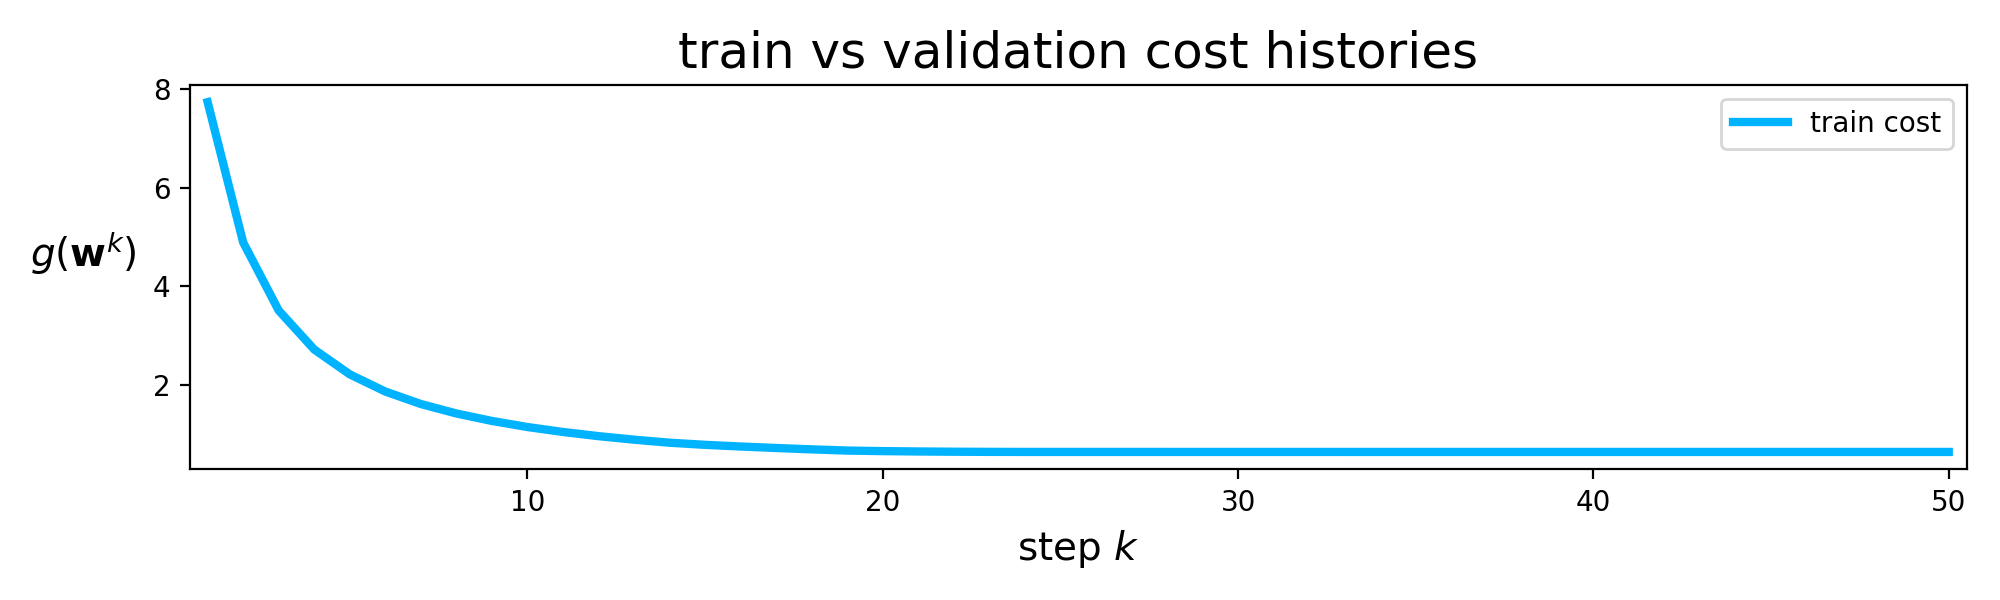

In [31]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib5 = pidlib.rnn_pid_lib.super_setup.Setup(x_car)

# normalize?
mylib5.preprocessing_steps(normalizer_name = 'none')

# split into training and validation sets
mylib5.make_train_val_split(train_portion = 1)

# choose cost
mylib5.choose_cost(control_loop,cost = least_absolute)

# fit an optimization
w = 0.1*np.random.randn(4,1)
# mylib5.fit(max_its = 59,alpha_choice = 10**(0),optimizer = 'gradient_descent',w_init = w,verbose = False)

mylib5.fit(max_its = 50,alpha_choice = 10**(0),optimizer = 'zero_order',w_init = w,verbose = False)

# show cost function history
mylib5.show_histories(start = 1)

<IPython.core.display.Javascript object>


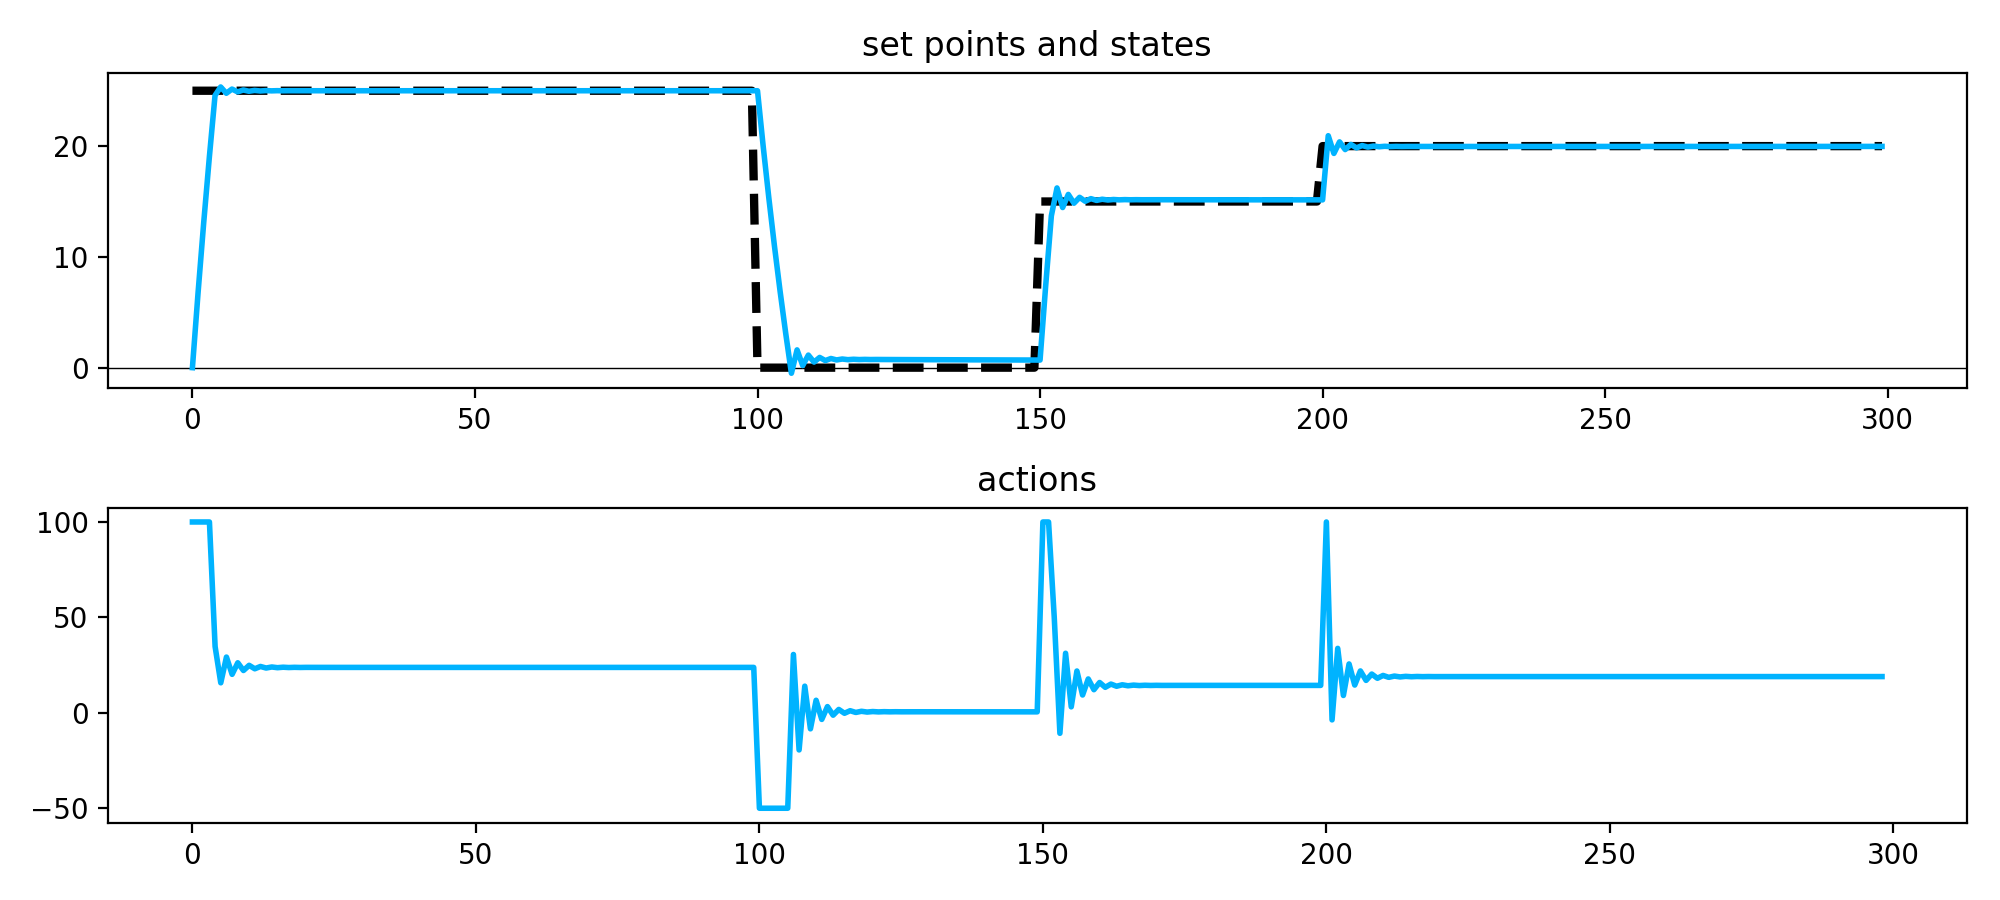

In [32]:
# This code cell will not be shown in the HTML version of this notebook
# Plot the standard normalized series and its training fit
pidlib.variable_order_plotters.plot_setpoint_train_val_sequences(mylib5)

- these actions are crazy when the desired speed ramps up and down - we can fix this by *regularizing*

#### <span style="color:#a50e3e;">Example: 2 </span> PID controller for two tank example

In [12]:
# This code cell will not be shown in the HTML version of this notebook
def two_tank_control_model(x,w):
    #### simulate vehicle response to set points ####
    s_t = [0.0,0.0]
    action_history = []
    state_history = [s_t]
    h = 0.0
    for t in range(np.size(x) - 1):
        # get current set point
        x_t = x[:,t]

        # update error
        e_t = x_t - s_t[1]
        
        # update integral of error
        h = h + e_t*0.1

        # set action based on PI linear combination
        a_t = w[0] + w[1]*e_t + w[2]*h 
        
        if t > 0:
            a_t += w[3]*(s_t[1] - state_history[-2][1])

        # clip inputs to -50% to 100%
        if a_t >= 100.0:
            a_t = 100.0
        if a_t <= 0.0:
            a_t = 0.0
    
        # cap off condition
        #if s_t[1] > x_t:
        #    a_t = 0
            
        # run pid controller
        s_t = demo_3.tank_model(a_t,s_t)
        
        # store results
        action_history.append(a_t)
        state_history.append(s_t)

    # transition to arrays
    state_history = np.array(state_history).T
    action_history = np.array(action_history)[np.newaxis,:]
    
    # return velocities and control history
    return state_history,action_history

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# an implementation of the least squares cost function for linear regression
def least_squares(w,x):
    states,actions = control_model(x,w)
    # compute cost over batch
    cost = np.sum((states[1,1:] - x[:,1:])**2)
    return cost/float(x.shape[1]-1)

# a compact least absolute deviations cost function
def least_absolute_deviations(w,x):
    states,actions = control_model(x,w)
    # compute cost over batch
    cost = np.sum(np.abs(states[1,1:] - x[:,1:]))
    return cost/float(x.shape[1]-1)

<IPython.core.display.Javascript object>


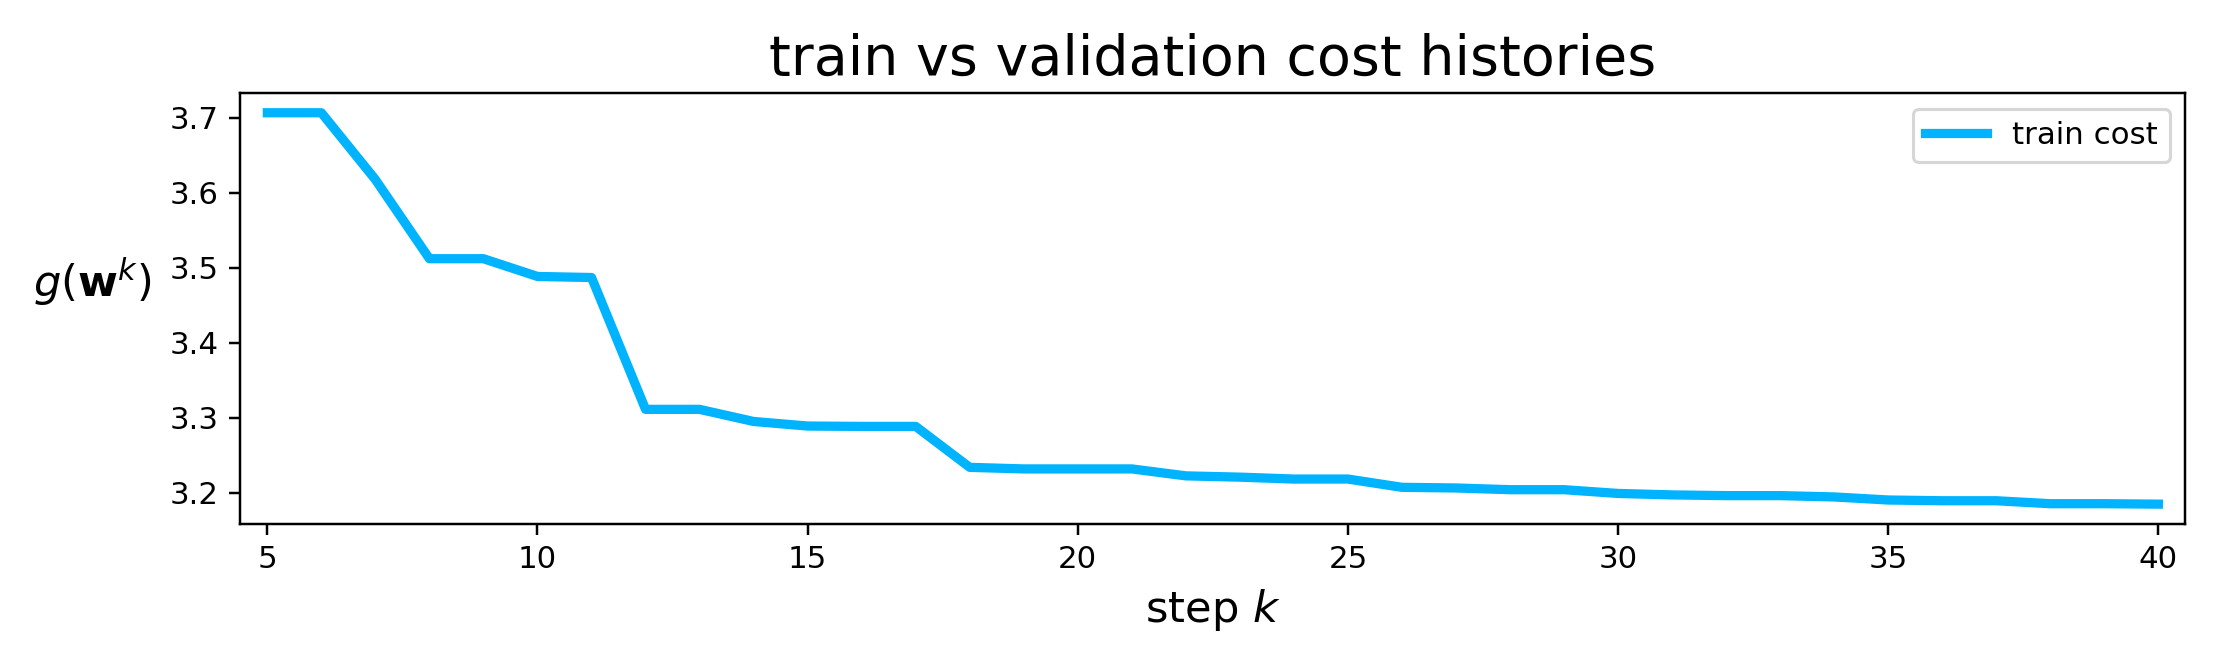

In [14]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib6 = pidlib.rnn_pid_lib.super_setup.Setup(x_tank2)

# split into training and validation sets
mylib6.make_train_val_split(train_portion = 1)

# choose cost
control_model = two_tank_control_model
mylib6.choose_cost(model = control_model,cost = least_absolute_deviations)

# fit an optimization
w = 0.1*np.random.randn(4,1)
mylib6.fit(max_its = 10,alpha_choice = 'diminishing',optimizer = 'zero_order',w_init = w,verbose = False)

# show cost function history
mylib6.show_histories(start = 5)

<IPython.core.display.Javascript object>


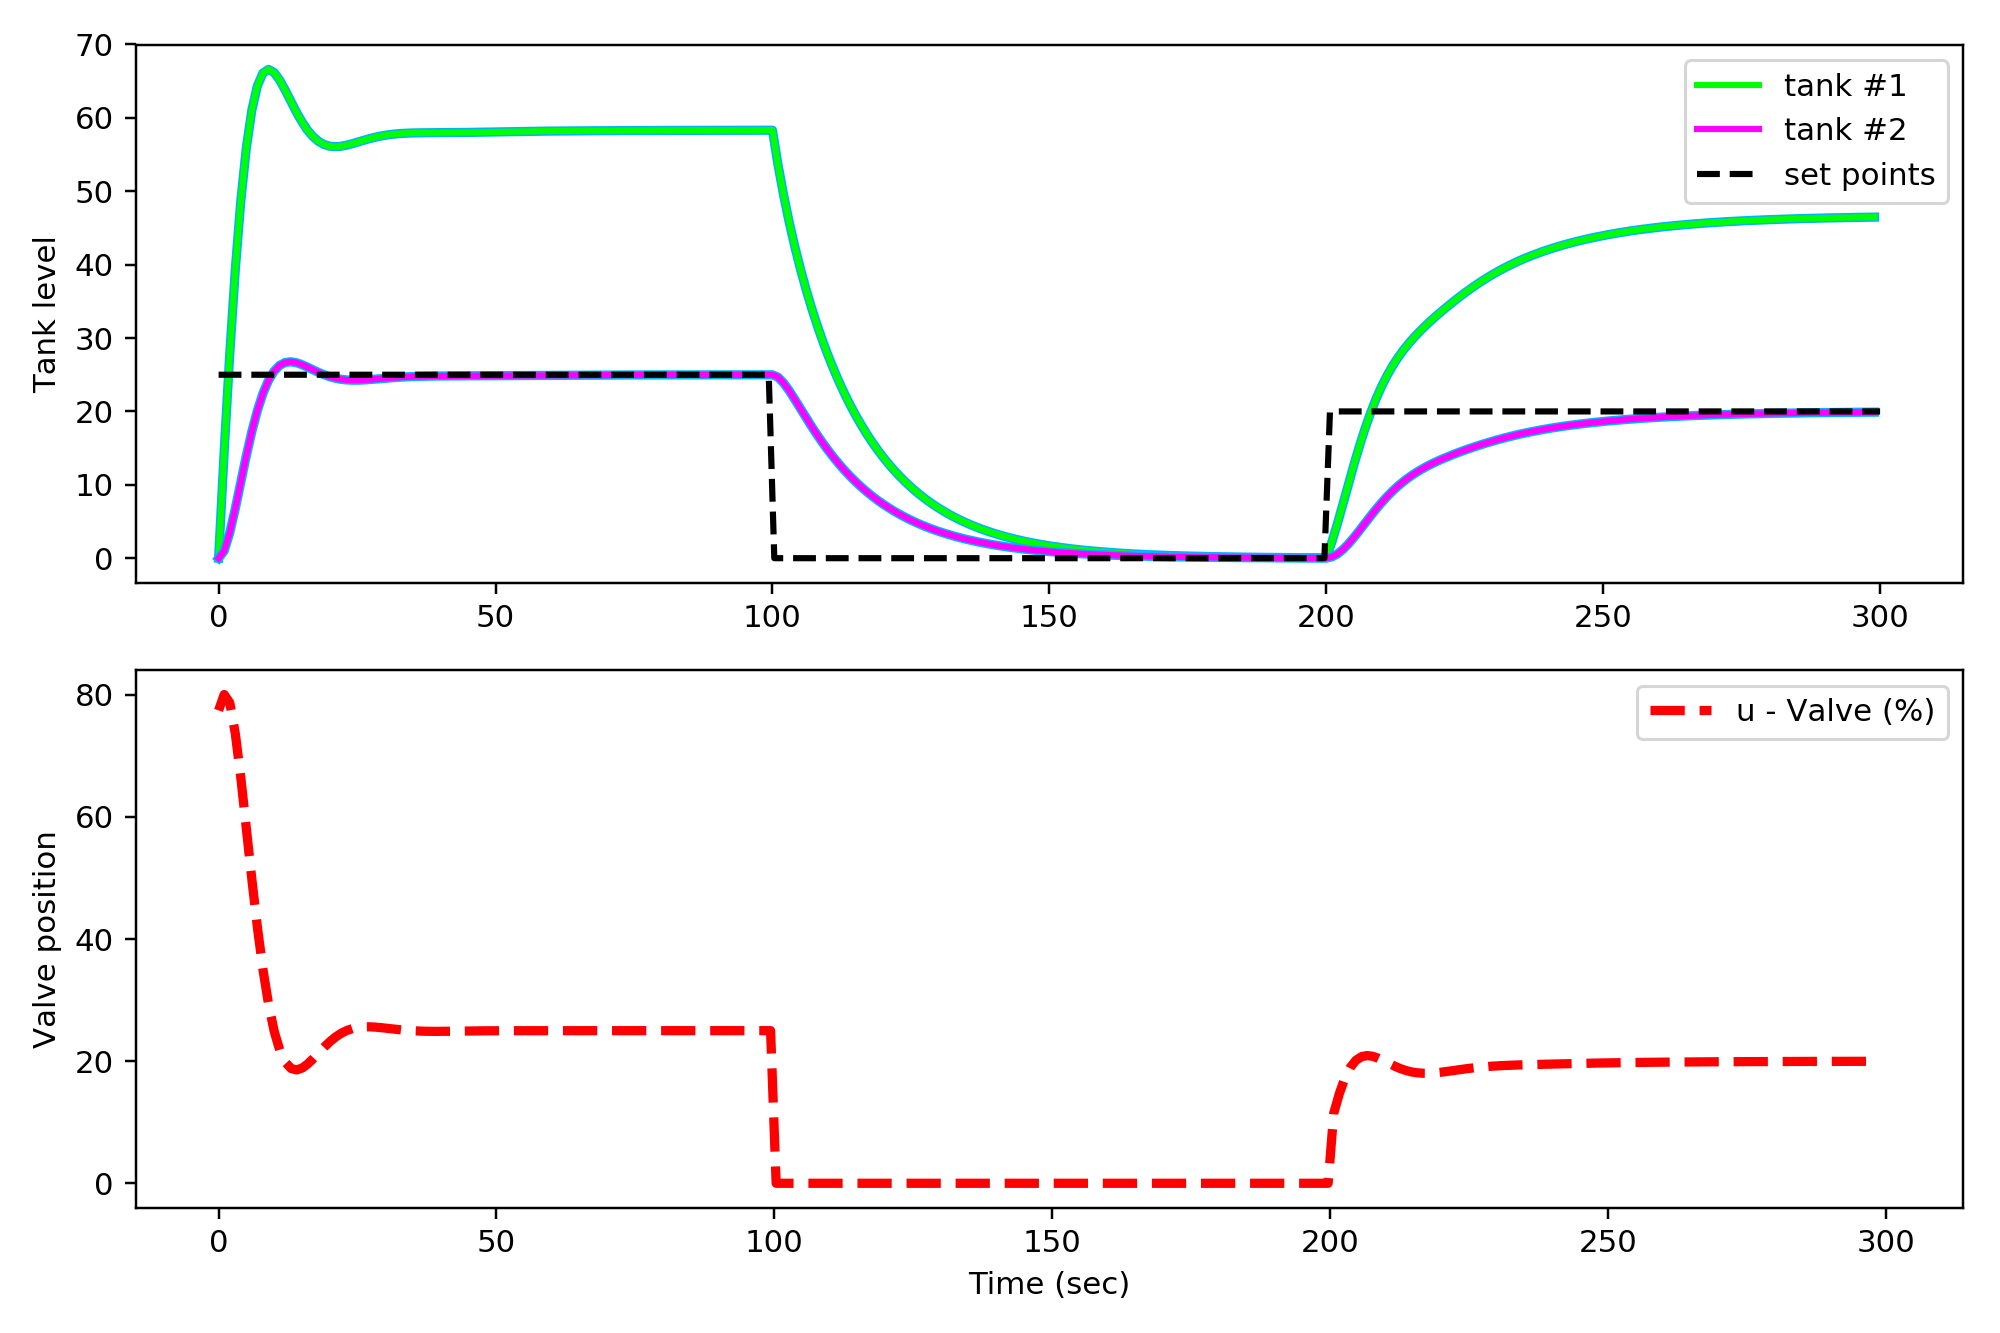

In [15]:
# This code cell will not be shown in the HTML version of this notebook
# plot results
pidlib.two_tank_plotter.plot_results(mylib6)